## LightGBM

### LightGBM이 XGboost보다 좋은 점

- 더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량
- 카테고리형 피처의 자동 변환과 최적 분할(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

### LightGBM

- 적은 데이터 세트(10,000개 이하)에 적용할 경우 과적합이 발생하기 쉽다는 단점 존재
- 대부분의 트리 기반 알고리즘은 균형 트리 분할(Level Wise) 방식으로 트리의 깊이를 최소화, 균형을 맞추기 위한 시간이 필요하다는 단점
- LightGBM은 **리프 중심 트리 분할(Leaf Wise)** 방식을 사용
- **리프 중심 트리 분할(Leaf Wise)**
    - 트리의 균형을 맞추지 않고, 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할
    - 트리의 깊이가 깊어진 비대칭적인 규칙 트리 생성
    - 최대 손실 값을 가지는 리프 노드를 지속적으로 분할 ⇒ 균형 트리 분할 방식보다 예측 오류 손실을 최소화

- 파이썬 패키지 ‘`**lightgbm**`’
    - XGBoost와 마찬가지로, 초기에는 파이썬 래퍼용 LightGBM만 개발되었으나 이후 사이킷런과의 호환성 지원을 위해 사이킷런 래퍼 LightGBM이 추가로 개발됨
- 사이킷런 래퍼 LightGBM 클래스
    - 분류: **`LGBMClassifier`**
    - 회귀: **`LGBMRegressor`**

### LightGBM 하이퍼 파라미터

- **num_iterations**
    - 반복 수행하려는 트리의 개수
    - 기본값 : 100
    - 크게 지정할수록 예측 성능이 높아질 수 있으나, 너무 크게 지정하면 과적합으로 성능 저하
- **learning_rate**
    - 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값
    - 0에서 1사이 값을 지정
    - 기본값 : 0.1
- **max_depth**
    - 최대 트리 깊이
    - 기본값 : -1
- **min_data_in_leaf**
    - 결정 트리의 min_samples_leaf 파라미터와 동일
    - 최종 결정 클래스인 리프 노드가 되기 위해 최소한으로 필요한 데이터 샘플 개수
    - 기본값: 20
- **num_leaves**
    - 하나의 트리가 가질 수 있는 최대 리프 개수
    - 기본값 : 31
- **boosting**
    - 부스팅의 트리를 생성하는 알고리즘
    - 기본값 : gbdt
    - gbdt : 일반적인 그래이던트 부스팅 결정 트리
    - rt: 랜덤 포레스트
- **bagging_fraction**
    - 사이킷런의 BGM &  XGBClassifier의 subsample 파라미터와 동일
    - 데이터를 샘플링하는 비율
    - 기본값 : 1.0
    - 트리가 커져서 과적합되는 것을 제어
- **feature_fraction**
    - GBM의 max_features 파라미터와 유사 / XGBClassifier의 colsample_bytree 파라미터와 동일
    - 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율, 과적합 제어
    - 기본값 : 1.0
- **lambda_l2**
    - XGBClassifier의 reg_lambda와 동일
    - L2 regulation 제어를 위한 값 ⇒ 피처 개수가 많을 경우 적용을 검토, 값이 클수록 과적합 감소
    - 기본값 : 0.0
- **lambda_l1**
    - XGBClassifier의 reg_alpha와 동일
    - L2 regulation 제어를 위한 값 ⇒ 피처 개수가 많을 경우 적용을 검토, 값이 클수록 과적합 감소
- **objective**
    - XGboost의 objective 파라미터와 동일
    - 최솟값을 가져야 할 손실 함수를 정의

| 파이썬 래퍼 LightGBM | 사이킷런 래퍼 LightGBM | 사이킷런 래퍼 XGBoost |
| --- | --- | --- |
| num_iterations | n_estimators | n_estimators |
| learning_rate | learning_rate | learning_rate |
| max_depth | max_depth | max_depth |
| min_data_in_leaf | min_child_samples | N/A |
| bagging_fraction | subsample | subsample |
| feature_fraction | colsample_bytree | colsample_bytree |
| lambda_l2 | reg_lambda | reg_lambda |
| lambda_l1 | reg_alpha | reg_alpha |
| early_stopping_round | early_stopping_rounds | early_stopping_rounds |
| num_leaves | num_leaves | N/A |
| min_sum_hessian_in_leaf | min_child_weight | min_child_weight |

### 하이퍼 파라미터 튜닝 방안

num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄임

### LightGBM 적용 - 위스콘신 유방암 예측

- **데이터 세트 로드 & 학습 및 예측 수행 (조기 중단)**

In [68]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

조기 중단으로 111번 반복까지만 수행하고 학습 종료

- **예측 성능 평가**

In [69]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [70]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


- **피처 중요도 시각화 - plot_importance()**

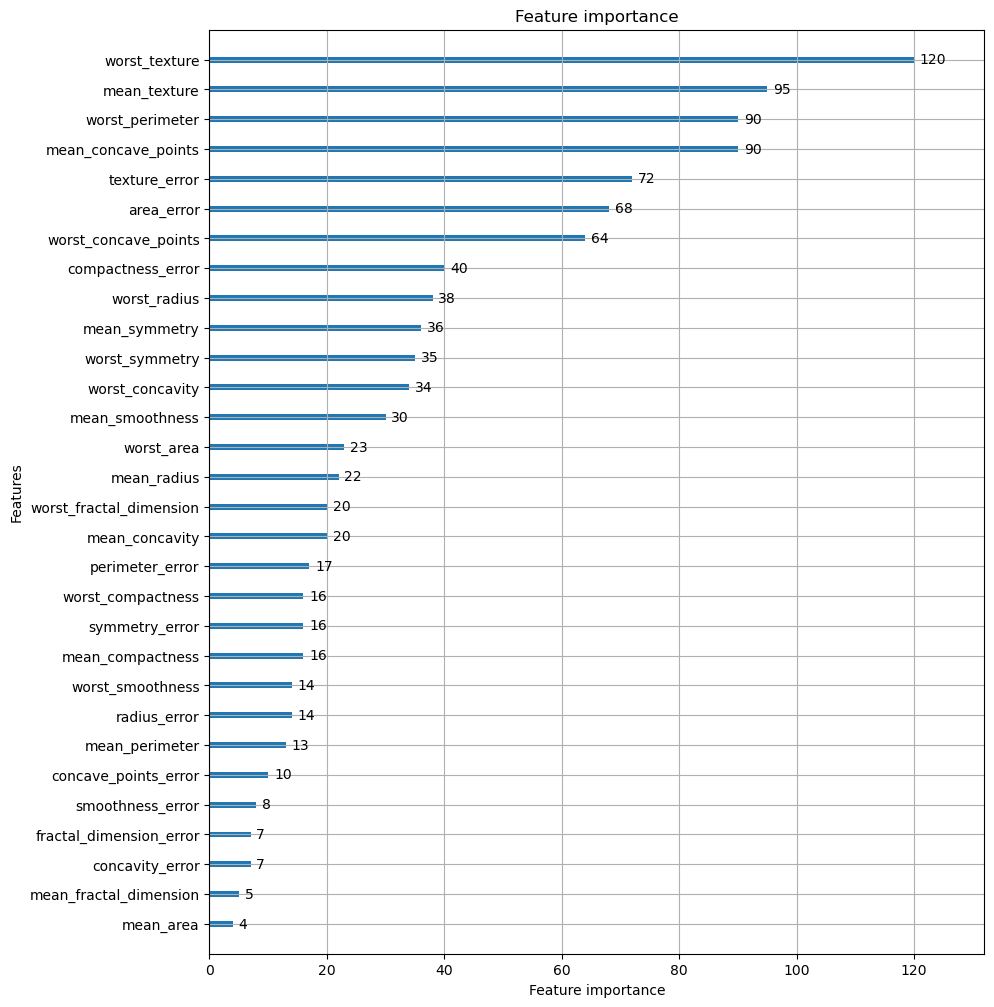

In [71]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

# 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

- 지금까지의 Grid Search 방식을 이용한 하이퍼 파라미터 튜닝은 튜닝해야 할 파라미터의 개수가 많을 경우 최적화 수행 시간이 오래 걸린다는 단점 존재
- XGBoost나 LightGBM은 하이퍼 파라미터 개수가 다른 알고리즘에 비해 많은 편
    
    ⇒ GridSearch 방식으로 최적 하이퍼 파라미터를 찾으려면 많은 시간 소모
    
- 따라서, 하이퍼 파라미터 튜닝 시 Grid Search가 아닌 다른 방식 적용 ⇒ **베이지안 최적화 기법**

## 베이지안 최적화

- 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식
- 예시
    - $f(x,y)=2x-3y$
    - $f(x,y)$ 의 반환 값을 최대/최소로 하는 $x,y$ 값을 찾아내는 것
- 함수 식 자체를 알 수 없고, 단지 입력값과 반환값만 알 수 있는 상황에서 함수 반환값의 최대/최소 값을 찾는 것은 매우 어려움
- 정확한 함수 식을 몰라도 수십 번의 입력값을 순차적으로 대입해 반환 값의 최대/최소를 찾을 수도 있지만, 많은 시간 소요
- **베이지안 최적화**
    - 베이지안 확률에 기반을 두고 있는 최적화 기법
    - 베이지안 확률
        - 새로운 사건의 관측이나 새로운 샘플 데이터를 기반으로 사후 확률을 개선해나감
        - 사후 확률
            
            
    - 새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적 함수 모델을 만들어냄
    - **대체 모델(Surrogate Model)**
        - 획득 함수로부터 최적 함수를 예측할 수 있는 입력값(하이퍼 파라미터)을 추천 받은 뒤, 이를 기반으로 최적 함수 모델을 개선
    - **획득 함수(Acquisition Function)**
        - 개선된 대체 모델을 기반으로 최적 입력값(하이퍼 파라미터)을 계산
        
        

### **베이지안 최적화 순서**

- **STEP 1**
    - 랜덤하게 하이퍼 파라미터들을 샘플링, 성능 결과 관측
    

    
    - 검은색 원 : 특정 하이퍼 파라미터가 입력되었을 때 관측된 성능 지표 결괏값을 의미
    - 주황색 사선 : 찾아야 할 목표 최적 함수를 의미
- **STEP 2**
    - 관측 값 기반으로 대체 모델이 최적 함수를 추정 (파란색 실선)
    - **신뢰 구간** : 추정된 함수의 결괏값 오류 편차, 추정 함수의 불확실성
    - **최적 관측값** : y축 value에서 가장 높은 값을 가질 때의 하이퍼 파라미터
    

    
- **STEP 3**
    - 추정된 최적 함수를 기반으로 획득 함수가 다음으로 관측할 하이퍼 파라미터 값을 계산
    - 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아 다음에 관측할 하이퍼 파라미터를 대체 모델에 전달
    

    
- **STEP 4**
    - 획득 함수로부터 받은 하이퍼 파라미터를 기반으로 대체 모델 갱신, 다시 최적 함수를 예측 추정
    
    

⇒ STEP 3, STEP 4를 반복하면 대체 모델의 불확실성이 개선, 점차 정확한 최적 함수 추정이 가능

## HypterOpt 사용하기

**HypterOpt**

: 베이지안 최적화를 ML 모델의 하이퍼 파라미터 튜닝에 적용할 수 있게 제공되는 파이썬 패키지 중 하나

### **HypterOpt의 활용 주요 로직**

1. 입력 변수명, 입력값의 검색 공간 (Search Space) 설정

2. 목적 함수 (Objective Function) 설정

3. 목적 함수 반환 최솟값을 가지는 최적 입력값 유추

⇒ HyperOpt는 목적 함수의 **최솟값**을 가지게하는 최적 입력값을 유추함 (최댓값 X)

### **입력 변수명, 값 검색 공간 설정**

- hyperopt의 `**hp`** 모듈을 사용하여 설정
- 입력 변수명, 입력값 검색 공간은 딕셔너리 형태로 설정
    - key = 입력 변수명 / value = 검색 공간
- **`hp.quniform('변수명', 시작 값, 끝 값, 간격)`**
- 예시
    - hp.quniform('x', -10, 10, 1): 입력 변수 x는 -10부터 10까지 1 간격으로 가짐

In [72]:
import hyperopt

print(hyperopt.__version__)

0.2.7


In [73]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1) }

### **입력값의 검색 공간을 제공하는 대표적인 함수**

- `hp.quniform(label, low, high, q)`
    - label로 지정된 입력값 변수 검색 공간을 최솟값 low에서 최댓값 high까지 q의 간격을 가지고 설정
- `hp.uniform(label, low, high)`
    - 최솟값 low에서 최댓값 high까지 정규 분포 형태의 검색 공간 설정
- `hprandin(label, upper)`
    - 0부터 최댓값 upper 까지 random한 정숫값으로 검색 공간 설정
- `hploguniform(label, low, high)`
    - exp(uniform(low, high) 값을 반환
    - 반환 값의 log 변환된 값은 정규 분포 형태를 가지는 검색 공간 설정
- `hp.choice(label, options)`
    - 검색 값이 문자열 또는 문자열과 숫자값이 섞여 있을 경우 설정
    - Options는 리스트나 튜플 형태로 제공

### **목적 함수 생성**

- 목적 함수는 반드시 변숫값과 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환하는 구조
- 목적 함수 반환 값은 딕셔너리 형태도 가능
    - 이 경우 `{loss':retval, 'status':STATUS_OK)}` 와 같이 loss와 status 키 값을 설정

In [74]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

### **목적 함수 반환값이 최소가 될 수 있는 최적의 입력값 유추**

- HyperOpt의 `**fmin**` 함수 이용
- **`fmin(objective, space, algo, max_evals, trials)`**
- **fmin() 함수의 주요 인자**
    - fn: objective_func과 같은 목적 함수
    - space: search_space와 같은 검색 공간 딕셔너리
    - algo: 베이지안 최적화 적용 알고리즘 (기본값 = tpe.suggest, HyperOpt의 기본 최적화 알고리즘인 TPE를 의미)
    - max_evals: 최적 입력값을 찾기 위한 입력값 시도 횟수
    - trials: 시도한 입력값 및 목적 함수 반환값 결과 저장
    - rstate: fmin() 수행마다 동일한 결과를 가질 수 있게 하는 랜덤 시드 값

In [75]:
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.43trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


x = -4.0, y = 12.0, x는 0에 가까울 수록 반환값이 최소로 근사

### max_evals 값 변경 후 최적값 유추

In [76]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|███████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 565.49trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


- x = 2, y = 15로 목적 함수의 최적 최솟값을 근사할 수 있는 결과 도출
- Grid Search와 같은 순차적으로 x, y 변숫값을 입력하여 값을 찾는 방식의 경우 수백 번의 반복이 필요
- 하지만, 베이지안 최적화로 20회만으로도 일정 수준값을 근사할 수 있음!

⇒ 상대적으로 최적값 탐색 시간을 많이 줄일 수 있음

### **Trials 객체 중요 속성**

- `**result**`
    - 함수 반복 수행시 반환되는 값을 가짐
    - 파이썬 리스트 형태
    - 개별 원소는 딕셔너리
    - 예: [{'loss': value, 'status': 'ok'}]
- `**vals**`
    - 함수 반복 수행시 입력 값을 가짐
    - 딕셔너리 형태
    - 개별 값은 리스트
    - 예: {'x': [-6.0, -4.0, 4.0, -4.0, 9.0,...]}
- **Trials 객체 속성 출력**

In [77]:
# fmin( )에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값} 와 같은 딕셔너리임. 
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [78]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [79]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성. 
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


DataFrame으로 좀 더 직관적으로 입력 변수 x, y와 반환값 loss를 확인할 수 있음

## HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

fmin()을 통해서 최적 입력값을 구하는 방법과 유사

1. 적용해야 할 하이퍼 파라미터와 검색 공간 설정
2. 목적 함수에서 XGBoost를 학습 후 예측 성능 결과를 반환 값으로 설정
3. fmin() 함수에서 목적 함수를 하이퍼 파라미터 검색 공간의 입력값들을 사용하여 최적의 예측 성능 결과를 반환하는 최적 입력값 결정

### **주의 사항 (목적 함수 관련)**

- HyperOpt는 입력값, 반환값이 모두 실수형이므로 **하이퍼 파라미터 입력시 형 변환**
- HyperOpt 목적 함수는 최솟값을 반환하도록 최적화해야 하므로, **좋은 성능 지표일 경우 -1을 곱해줌**

### **입력 변수명, 입력값의 검색 공간 (Search Space) 설정**

- Search Space 객체에 max_depth, learning_rate, colsample_bytree 값 설정
- `hp.quniform`, `hp.uniform`으로 검색 공간 설정

In [80]:
# 아래 코드는 이전에 수록된 코드라 책에는 싣지 않았습니다. 
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [81]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [82]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

### **목적 함수(Objective Function) 설정**

- 검색 공간에서 목적 함수로 입력되는 모든 인자들은 실수형 값이므로, 하이퍼 파라미터 입력값을 정수형으로 형 변환
- 좋은 성능 지표일 경우 -1을 곱한 뒤 반환 ⇒ 더 큰 성능 지표가 더 작은 반환값이 되도록 함 (fmin() 함수는 최솟값을 최적화하므로 더 작은 수를 더 좋은 최적화로 판단)

In [83]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}


### 최적 하이퍼 파라미터 도출

In [84]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)


100%|███████████████████████████████████████████████| 50/50 [00:11<00:00,  4.19trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


- 값이 전부 **실수형**으로 도출되었음에 유의
- 정수형 하이퍼 파라미터인 max_depth, min_child_weight도 실수형으로 도출되었기 때문에 형 변환 필요
- 정수형 하이퍼 파라미터는 정수형으로 형 변환, 실수형 하이퍼 파라미터는 소수점 5자리까지만 변환하여 확인

In [85]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.54241, learning_rate:0.12601, max_depth:17, min_child_weight:2


### 최적 하이퍼 파라미터로 XGBClassifier 재학습 후 성능 평가

In [86]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [87]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)


[0]	validation_0-logloss:0.58942	validation_1-logloss:0.62048
[1]	validation_0-logloss:0.50801	validation_1-logloss:0.55913
[2]	validation_0-logloss:0.44160	validation_1-logloss:0.50928
[3]	validation_0-logloss:0.38734	validation_1-logloss:0.46815
[4]	validation_0-logloss:0.34224	validation_1-logloss:0.43913
[5]	validation_0-logloss:0.30425	validation_1-logloss:0.41570
[6]	validation_0-logloss:0.27178	validation_1-logloss:0.38953
[7]	validation_0-logloss:0.24503	validation_1-logloss:0.37317
[8]	validation_0-logloss:0.22050	validation_1-logloss:0.35628
[9]	validation_0-logloss:0.19873	validation_1-logloss:0.33798
[10]	validation_0-logloss:0.17945	validation_1-logloss:0.32463
[11]	validation_0-logloss:0.16354	validation_1-logloss:0.31384
[12]	validation_0-logloss:0.15032	validation_1-logloss:0.30607
[13]	validation_0-logloss:0.13813	validation_1-logloss:0.30143
[14]	validation_0-logloss:0.12798	validation_1-logloss:0.29513
[15]	validation_0-logloss:0.11926	validation_1-logloss:0.28891
[1

# 분류 실습 - 캐글 산탄데르 고객 만족 예측

## 산탄데르 고객 만족 dataset

- 캐글의 산탄데르 고객 만족(Santander Customer Satisfaction) dataset에 대해, 고객 만족 여부를 XGBoost와 LightGBM으로 예측
- 산탄데르 고객 만족 dataset
    - 370개의 피처
        - 피처 이름은 모두 익명 처리되어 어떤 속성인지는 추정할 수 없음
    - TARGET 속성의 값이 1이면 불만이 많은 고객, 0이면 만족한 고객
- 모델 성능 평가는 ROC-AUC로 평가
    - 대부분이 만족이고 불만족인 데이터는 일부일 것이기 때문에 정확도 수치보다는 ROC-AUC가 더 적합

## 데이터 전처리

- **필요한 모듈과 학습 데이터 로딩**

In [88]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("./train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


클래스 값 컬럼을 포함한 피처가 371개 존재

- **피처의 타입과 Null 값 확인**

In [89]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


111개의 피처가 float 형, 260개의 피처가 int 형 ⇒ 모든 피처가 숫자형이며, Null 값 존재 X

- **전체 데이터에서 만족과 불만족의 비율 확인**

In [90]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


- **각 피처의 값 분포 확인**

In [91]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


- var3 칼럼의 경우 min 값이 -999999 ⇒ NaN이나 특정 예외 값을 -999999로 변환했을 것으로 추정
- var3은 숫자 형이고, 다른 값에 비해 -999999는 너무 편차가 심하므로 해당 값을 가장 값이 많은 2로 변환
- ID 피처는 단순 식별자에 불과하므로 피처를 드롭
- 피처 세트와 레이블 세트 분리

In [92]:
cust_df['var3'].value_counts()

var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: count, Length: 208, dtype: int64

- **var3의 -999999 값을 2로 대체 & ID 피처 드롭 & 피처 세트와 레이블 세트 분리**

In [93]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))


피처 데이터 shape:(76020, 369)


- **학습 데이터 세트와 테스트 데이터 세트 분리**

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


- **학습 데이터에서 검증 데이터 세트 분리**
    - XGBoost의 조기 중단의 검증 데이터 세트로 사용하기 위함

In [95]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

## XGBoost 모델 학습과 하이퍼 파라미터 튜닝

- **XGBoost의 학습 모델을 생성 & 예측 결과를 ROC AUC로 평가**

In [96]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

- **HyperOpt를 이용해 베이지안 최적화 기반으로 XGBoost의 하이퍼 파라미터 튜닝**
    1. **하이퍼 파라미터 검색 공간 설정**

In [97]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

2. **목적 함수 설정**

In [98]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

3. **fmin() 함수를 호출해 최적 하이퍼 파라미터 도출**

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[0]	validation_0-auc:0.81678	validation_1-auc:0.79160                                                                  
[1]	validation_0-auc:0.82454	validation_1-auc:0.79688                                                                  
[2]	validation_0-auc:0.83323	validation_1-auc:0.80572                                                                  
[3]	validation_0-auc:0.83854	validation_1-auc:0.81095                                                                  
[4]	validation_0-auc:0.83847	validation_1-auc:0.80989                                                                  
[5]	validation_0-auc:0.83879	validation_1-auc:0.80978                                                                  
[6]	validation_0-auc:0.84053	validation_1-auc:0.81042                                                                  
[7]	validation_0-auc:0.84129	validation_1-auc:0.81116                                                                  
[8]	validation_0-auc:0.84224	validation_

4. **도출된 최적 하이퍼 파라미터를 기반으로 XGBClassifier 재학습 & ROC AUC 측정**

In [ ]:
# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5)   
                       )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

5. **각 피처의 중요도 시각화 - plot_importance()**

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15

## LightGBm 모델 학습과 하이퍼 파라미터 튜닝

- **동일한 데이터 세트를 기반으로 LightGBM 학습 수행 & ROC-AUC 측정**

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

- **HyperOpt를 이용하여 다양한 하이퍼 파라미터에 대한 튜닝 수행**
    1. **하이퍼 파라미터 검색 공간 설정**

In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }

2. **목적 함수 설정**

In [ ]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']), 
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1]) 
        roc_auc_list.append(score)
    
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

3. **fmin()을 호출하여 최적 하이퍼 파라미터 도출**

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출. 
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

4. **최적 하이퍼 파라미터를 이용하여 LightGBM 학습 & ROC-AUC 평가**

In [ ]:
lgbm_clf =  LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']), 
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5)
                          )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

# 분류 실습 - 캐글 신용카드 사기 검출

### 캐글 신용카드 데이터 세트

- 레이블인 Class 속성은 매우 불균형한 분포
- Class는 0과 1로 분류
    - 0 : 사기가 아닌 정상적인 신용카드 트랜잭션 데이터
    - 1 : 사기 트랜잭션
- 일반적으로, 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection)과 같은 데이터 세트에서 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적음 ⇒ 레이블 값이 극도로 불균형한 분포를 가짐

### 언더 샘플링과 오버 샘플링

- 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못함
- 반면, 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행하여 제대로 된 이상 데이터 검출이 어려움
    
    ⇒ 적절한 학습 데이터를 확보하는 방안이 필요 ⇒ 오버 샘플링 & 언더 샘플링
- **언더 샘플링**
    - 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소
    - 예시
        - 정상 레이블을 가진 데이터가 10,000건, 이상 레이블을 가진 데이터가 100건이 있으면 정상 레이블 데이터를 100건으로 줄여 버리는 방식
- **오버 샘플링**
    - 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식
    - 동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식
    - 대표적으로 **SMOTE(Synthetic Minority Over-sampling Technique)** 방법 존재
        - 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 k개 이웃들의 차이를 일정 값으로 만들어, 기존 데이터와 약간 차이가 나는 새로운 데이터 생성
- 파이썬 패키지 imbalanced-learn

### 데이터 일차 가공 및 모델 학습/예측/평가

- **모듈 임포트 및 데이터 세트 로드**

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

- V로 시작하는 피처들의 의미를 알 수 없음
- Time 피처의 경우, 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없기에 제거
- Amount 피처는 신용카드 트랜잭션 금액을 의미
- Class는 레이블로서 0의 경우 정상, 1의 경우 사기 트랜젝션
- 전체 284,807개의 레코드에서 결측치는 없으며, Class 레이블만 int형이고 나머지 피처들은 모두 float형

- **get_preprocessed_df() 함수**
    - 불필요한 Time 피처를 삭제

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

- **get_train_test_dataset() 함수**
    - get_preprocessed_df() 함수 호출
    - 학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트 반환

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

- **로지스틱 회귀를 이용해 신용 카드 사기 여부 예측**

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

- **LightGBM을 이용해 신용 카드 사기 여부 예측**

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 데이터 분포도 변환 후 모델 학습/예측/평가

- 로지스틱 회귀는 선형 모델
- 대부분의 선형 모델은 중요 피처들의 값이 **정규 분포** 형태를 유지하는 것을 선호
- Amount 피처는 신용 카드 사용 금액으로, 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높음

- **Amount 피처의 분포도 확인**

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

- Amount, 즉 카드 사용금액이 1000불 이하인 데이터가 대부분
- 26,000불까지는 드물지만 많은 금액을 사용한 경우가 발생하면서 **꼬리가 긴 형태의 분포** 곡선

- **Amount를 표준 정규 분포 형태로 변환**

In [ ]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

- **학습/테스트 데이터 세트 생성 & 로지스틱 회귀와 LightGBM 모델을 학습/예측/평가**

In [ ]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


- **로그 변환**
    - 데이터 분포도가 심하게 왜곡되어 있을 경우 로그 변환을 적용
    
    ⇒ 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선
    
    - 넘파이의 **`log1p()`** 함수

In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 이상치 데이터 제거 후 모델 학습/예측/평가

- **이상치 데이터(Outlier)**
    - 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터
    - 머신러닝 모델의 성능에 영향
- 이상치를 찾는 방법으로 **IQR(Inter Quantile Range)** 방식을 적용
- **IQR(Inter Quantile Range)**
    - 사분위(Quantile) 값의 편차를 이용
    - 박스 플롯(Box Plot) 방식으로 시각화
    - **사분위(Quantile)**
        - 전체 데이터를 값이 높은 순으로 정렬하고, 이를 1/4(25%)씩으로 구간을 분할하는 것
        - IQR : 25%(Q1) ~ 75%(Q3) 범위
        
        
    - IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤, 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주
        - Q3 + IQR * 1.5 : 일반적인 데이터가 가질 수 있는 최댓값
        - Q1 - IQR * 1.5 : 일반적인 데이터가 가질 수 있는 최솟값
    - 경우에 따라 1.5가 아닌 다른 값을 적용 가능
    - **박스 플롯(Box Plot)**
        - IQR 방식을 시각화한 도표
        
        
- IQR을 이용해 이상치 데이터를 제거
- 매우 많은 피처가 있을 경우, 이들 중 결정값(레이블)과 가장 상관성이 높은 피처들을 위주로 이상치 ㅓㅁ출
- **각 피처별로 상관도 구하기 & 시각화**
    - DataFrame의 corr() 을 이용해 각 피처별로 상관도를 구함
    - 시본의 heatmap을 통해 시각화

In [ ]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

- cmap = ‘RdBu’ 로 설정
    - 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까움
    - 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가까움
- 맨 아래에 위치한 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14, V17

- **V14에 대해 이상치를 찾아 제거**

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index
    

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

In [ ]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


이상치 데이터를 제거한 뒤, 예측 성능이 크게 향상

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

- SMOTE는 `**imbalanced_learn**` 패키지의 `**SMOTE**` 클래스를 이용해 구현 가능
- 반드시 **학습 데이터 세트만 오버 샘플링**을 적용
    - 검증/테스트 데이터 세트를 오버 샘플링할 경우, 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증/테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없음

- **SMOTE 객체의 fit_resample() 메서드를 이용해 학습 피처/레이블 데이터를 증식**

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

- SMOTE 적용 전 학습 데이터 세트는 199,362건이었지만, SMOTE 적용 후 2배에 가까운 398,040건으로 데이터 증식
- SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199,020건으로 생성

- **생성된 학습 데이터 세트를 기반으로 로지스틱 회귀 모델 학습 & 성능 평가**

In [ ]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)


- 재현율은 크게 증가했지만, 반대로 정밀도가 급격하게 저하
- 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 훨씬 많은 Class=1 데이터를 학습 ⇒ 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 하락

- **분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 시각화**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    


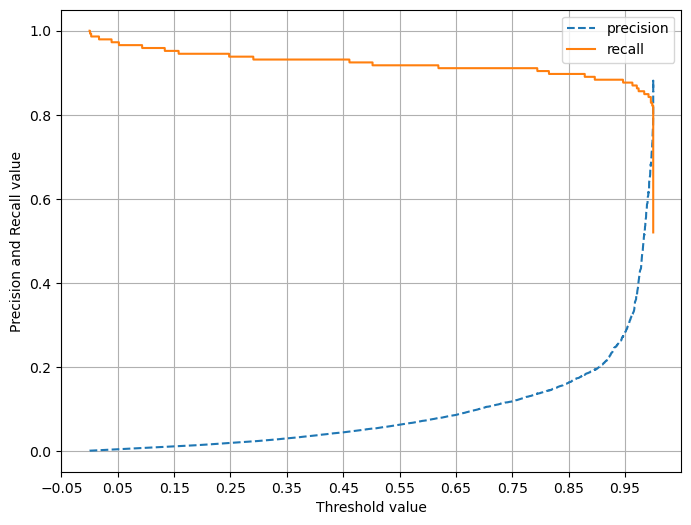

In [26]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

- 임곗값 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮음
- 임곗값 0.99 이상에서는 재현율이 대폭 떨어지고 정밀도가 높아짐

⇒ 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀값을 얻을 수 없음

- **생성된 학습 데이터 세트를 기반으로 LightGBM 모델 학습 & 성능 평가**

In [27]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


- 재현율은 높아졌으나, 정밀도는 낮아짐 (SMOTE를 적용했을 때의 일반적인 결과)

# 스태킹 앙상블

- **스태킹(Stacking)**
    - 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출
    - 배깅/부스팅과 달리, 개별 알고리즘으로 예측한 데이터를 기반으로 **다시 예측**을 수행
    - 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어, 별도의 ML 알고리즘으로 최종 학습을 수행 → 테스트 데이터를 기반으로 다시 최종 예측을 수행
        - **메타 모델** : 개별 모델의 예측된 데이터 세트를 기반으로 다시 학습하고 예측하는 방식
    - 분류 뿐만 아니라 회귀에도 적용 가능
- **스태킹 모델**
    - 개별적인 기반 모델
    - 최종 메타 모델 : 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습
- 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합 → 최종 메타 모델의 학습용/테스트용 피처 데이터 세트로 만듦
- 스태킹을 적용할 때는 많은 개별 모델이 필요(2~3개의 개별 모델만을 결합해서는 예측 성능 향상 불가)
    
    
- **M X N 데이터 세트에 스태킹 앙상블 적용**
    - 사용할 ML 알고리즘 모델이 3개일 때, 각 모델은 예측 결과로 M개의 로우를 가진 1개의 레이블 값을 도출
    - 모델별로 도출된 예측 레이블 값을 다시 합해(스태킹) M X 3 (모델 개수) 의 새로운 데이터 세트 생성
    - 이렇게 스태킹된 데이터 세트에 최종 모델을 적용해 최종 예측을 수행
    

### 기본 스태킹 모델

- **데이터 세트 로딩 & 학습/테스트 데이터 세트 분리**

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

- **스태킹에 사용될 머신러닝 알고리즘 클래스 생성**
    - 개별 모델 : KNN, 랜덤 포레스트, 결정 트리, 에이다부스트
    - 최종 모델 : 로지스틱 회귀

In [ ]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)


- **개별 모델 학습 및 정확도 측정**

In [ ]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

- **스태킹으로 최종 메타 모델의 학습 데이터 생성**
    - 개별 모델의 예측값을 칼럼 레벨로 (옆으로) 붙여서 최종 메타 모델의 학습 데이터 생성
    - 반환된 예측 데이터가 1차원의 ndarray이므로, 행 형태로 붙인뒤 transpose()로 행렬 전치

In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

행과 열이 바뀐 것을 확인할 수 있음

- **최종 메타 모델로 학습 후 예측 정확도 측정**

In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

- 개별 모델의 예측 정확도보다 향상됨
- 그러나 스태킹 기법의 예측이 무조건 개별 모델보다 나은 것은 아님

## CV 세트 기반 스태킹

- 과적합 개선을 위해, 최종 메타 모델의 데이터 세트 생성 시 **교차 검증** 기반으로 예측된 결과 데이터 세트를 이용
- 앞 예제에서는 학습 데이터가 아닌 테스트용 데이터로 학습했으므로 과적합 문제 발생 가능
- 이를 개선하기 위해 개별 모델이 각각 **교차 검증**으로 학습용/예측(테스트)용 스태킹 데이터를 생성한 뒤, 이를 기반으로 메타 모델이 학습 및 예측을 수행

### **STEP 1**

- **각 모델 별로 학습/테스트 데이터를 예측한 결과 값을 기반으로 학습용/테스트용 데이터를 생성**
- 책에서는 3개의 폴드 세트로 가정
1. **학습용 데이터를 N개의 폴드(Fold)로 생성 & 2개의 학습 데이터 폴드 기반으로 개별 모델을 학습**
    - 2개 = 학습을 위한 데이터 폴드
    - 1개 = 검증을 위한 데이터 폴드
        
2. **학습된 개별 모델을 1개의 검증 폴드로 예측 및 결과 저장**
    - 로직을 3번 반복하면서 예측 데이터 생성 → 메타 모델 학습 데이터로 사용
3. **학습된 개별 모델이 원본 테스트 데이터를 예측하여 예측값 생성**
    - 로직을 3번 반복하면서 예측값의 평균으로 최종 결괏값 생성 → 메타 모델 테스트 데이터로 사용

⇒ 최종 메타 모델 학습 데이터, 테스트 데이터 생성

### **STEP 2**

- STEP 1에서 각 모델이 생성한 학습 데이터, 테스트 데이터를 모두 합쳐 최종 메타 모델이 사용할 데이터로 생성

### CV 기반 스태킹 구현

- **각 모델별 데이터 생성 함수 구현**
    - get_stacking_base_datasets() 함수
        - 각 모델에서 학습 및 테스트 데이터를 생성
        - 파라미터 : 개별 모델의 Clasifer 객체, 원본 학습용 피처 데이터, 원본 학습용 레이블 데이터, 원본 테스트 피처 데이터, 폴드 개수
        - 함수 내에서 폴드 개수만큼 반복 수행
        - 폴드된 학습용 데이터로 학습한 뒤 예측 결괏값을 기반으로 메타 모델을 위한 학습/테스트용 데이터 생성

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

- **각 모델 별로 메타 모델이 추후에 사용할 학습용/테스트용 데이터 생성 및 저장**

In [ ]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

- **각 모델별 학습 데이터 및 테스트 데이터를 concatenate()로 합치기**

In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

- **최종 메타 모델의 학습 및 예측 정확도 구하기**

In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))